In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
openvas_df = pd.read_json('OpenvasLookup.json')
openvas_df_vulns = openvas_df.query('cvss != 0.0') # Filter info vulns

In [3]:
openvas_df_vulns.head()
data_text = openvas_df_vulns[['plugin_name']]
data_text['index'] = data_text.index
documents = data_text

/home/chucho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
print(len(documents))
print(documents[:5])

47392
                                plugin_name  index
19             Microsofts SQL Version Query     19
108  netstat Service Information Disclosure    108
172                    QMTP Open Relay Test    172
208     IPMI Default Password Vulnerability    208
232         LinuxConf grants network access    232


Data Pre-processing

We will perform the following steps:

    Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
    Words that have fewer than 3 characters are removed.
    All stopwords are removed.
    Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
    Words are stemmed — words are reduced to their root form.

In [5]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/chucho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
doc_sample = documents[documents['index'] == 4310].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Fedora', 'Update', 'for', 'firefox', 'FEDORA-2011-11106']


 tokenized and lemmatized document: 
['fedora', 'update', 'firefox', 'fedora']


In [8]:
processed_docs = documents['plugin_name'].map(preprocess)
processed_docs[4310]

['fedora', 'update', 'firefox', 'fedora']

In [9]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 microsofts
1 query
2 version
3 disclosure
4 information
5 netstat


In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    count += 1
    if v == 'splunk':
        print(k)
        break

1043


In [11]:
#dictionary.filter_extremes()
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]],
                                                     bow_doc_4310[i][1]))

Word 99 ("snmp") appears 1 time.
Word 128 ("update") appears 1 time.
Word 136 ("centos") appears 2 time.
Word 137 ("cesa") appears 1 time.


In [12]:
my_bow_corpus = dictionary.doc2bow(processed_docs[108])
my_bow_corpus

[(3, 1), (4, 1), (5, 1), (6, 1)]

In [13]:
for i in range(len(my_bow_corpus)):
    print("Word {} (\"{}\") appears {} time.".format(my_bow_corpus[i][0], 
                                                     dictionary[my_bow_corpus[i][0]],
                                                     my_bow_corpus[i][1]))

Word 3 ("disclosure") appears 1 time.
Word 4 ("information") appears 1 time.
Word 5 ("netstat") appears 1 time.
Word 6 ("service") appears 1 time.


In [14]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6768979318863587), (1, 0.56445502148102), (2, 0.47244017455423054)]


In [15]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        print("training with topic %s" % num_topics)
        #lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=9)
        lm_list.append(lm)
        cm = gensim.models.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v



training with topic 1
training with topic 2
training with topic 3
training with topic 4
training with topic 5
training with topic 6
training with topic 7
training with topic 8
training with topic 9
training with topic 10
training with topic 11
training with topic 12
training with topic 13
training with topic 14
training with topic 15
training with topic 16
training with topic 17
training with topic 18
training with topic 19


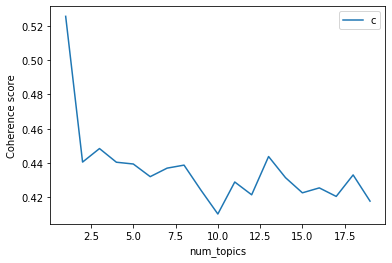

In [16]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, limit=20)

In [17]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)

In [18]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.115*"vulnerability" + 0.095*"file" + 0.066*"core" + 0.051*"injection" + 0.034*"vmware" + 0.025*"joomla" + 0.022*"local" + 0.022*"component" + 0.020*"parameter" + 0.018*"include"
Topic: 1 
Words: 0.148*"openssl" + 0.073*"update" + 0.068*"graphicsmagick" + 0.058*"mandriva" + 0.053*"mdvsa" + 0.049*"moodle" + 0.032*"vulnerability" + 0.023*"subversion" + 0.020*"freeradius" + 0.015*"pixbuf"
Topic: 2 
Words: 0.558*"fedora" + 0.277*"update" + 0.018*"kernel" + 0.010*"mingw" + 0.010*"python" + 0.010*"drupal" + 0.004*"nodejs" + 0.003*"perl" + 0.003*"pdns" + 0.003*"bind"
Topic: 3 
Words: 0.103*"vulnerability" + 0.046*"base" + 0.043*"macosx" + 0.042*"open" + 0.034*"libreoffice" + 0.030*"client" + 0.029*"file" + 0.029*"mediawiki" + 0.026*"heap" + 0.023*"typo"
Topic: 4 
Words: 0.141*"apache" + 0.087*"vulnerability" + 0.067*"mysql" + 0.064*"tomcat" + 0.036*"openssh" + 0.032*"detection" + 0.030*"poppler" + 0.024*"windows" + 0.021*"community" + 0.020*"memory"
Topic: 5 
Words: 0.238*"u

In [19]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.052*"windows" + 0.045*"vulnerabilities" + 0.044*"multiple" + 0.042*"microsoft" + 0.032*"vulnerability" + 0.025*"mozilla" + 0.022*"security" + 0.020*"code" + 0.020*"execution" + 0.020*"mysql"
Topic: 1 Word: 0.056*"fedora" + 0.049*"rhsa" + 0.049*"redhat" + 0.029*"update" + 0.023*"qemu" + 0.019*"curl" + 0.016*"postgresql" + 0.015*"security" + 0.014*"ubuntu" + 0.012*"phpmyadmin"
Topic: 2 Word: 0.097*"oracle" + 0.093*"check" + 0.090*"local" + 0.076*"linux" + 0.074*"elsa" + 0.027*"alas" + 0.027*"amazon" + 0.020*"java" + 0.017*"imagemagick" + 0.014*"fedora"
Topic: 3 Word: 0.040*"gentoo" + 0.040*"glsa" + 0.038*"security" + 0.030*"advisory" + 0.024*"chromium" + 0.022*"vulnerabilities" + 0.022*"multiple" + 0.020*"apple" + 0.020*"vulnerability" + 0.018*"fedora"
Topic: 4 Word: 0.088*"fedora" + 0.036*"bind" + 0.030*"update" + 0.025*"firefox" + 0.021*"suse" + 0.018*"opensuse" + 0.017*"ruby" + 0.016*"seamonkey" + 0.015*"openssh" + 0.015*"graphicsmagick"
Topic: 5 Word: 0.247*"fedora" 

In [20]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8416568636894226	 
Topic: 0.235*"update" + 0.148*"centos" + 0.136*"opensuse" + 0.125*"suse" + 0.074*"cesa" + 0.044*"redhat" + 0.044*"rhsa" + 0.025*"kernel" + 0.019*"thunderbird" + 0.011*"samba"


In [21]:
unseen_document = 'Splunk enterprise vulnerability'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.4945882260799408	 Topic: 0.115*"vulnerability" + 0.095*"file" + 0.066*"core" + 0.051*"injection" + 0.034*"vmware"
Score: 0.28040415048599243	 Topic: 0.082*"default" + 0.074*"freebsd" + 0.072*"port" + 0.064*"credentials" + 0.041*"tiff"
Score: 0.012500422075390816	 Topic: 0.148*"openssl" + 0.073*"update" + 0.068*"graphicsmagick" + 0.058*"mandriva" + 0.053*"mdvsa"
Score: 0.012500422075390816	 Topic: 0.558*"fedora" + 0.277*"update" + 0.018*"kernel" + 0.010*"mingw" + 0.010*"python"
Score: 0.012500422075390816	 Topic: 0.103*"vulnerability" + 0.046*"base" + 0.043*"macosx" + 0.042*"open" + 0.034*"libreoffice"
Score: 0.012500422075390816	 Topic: 0.141*"apache" + 0.087*"vulnerability" + 0.067*"mysql" + 0.064*"tomcat" + 0.036*"openssh"
Score: 0.012500422075390816	 Topic: 0.238*"update" + 0.122*"ubuntu" + 0.100*"firefox" + 0.073*"python" + 0.027*"ruby"
Score: 0.012500422075390816	 Topic: 0.235*"update" + 0.148*"centos" + 0.136*"opensuse" + 0.125*"suse" + 0.074*"cesa"
Score: 0.012500422075